In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cPickle as pickle
import scipy.io
import time
from scipy.cluster.vq import kmeans2
from skimage import color

%matplotlib inline

In [216]:
# Save variables for simulations
start_time = time.time()
pickle.dump([W_EE, W_EI, W_IE, W_II, OP_map, OD_map, SS_E, SS_I, results_E, results_I, sum_field_sizes_E, sum_field_sizes_I, res_E, res_I], open('saved_vars/Aug-14-results.p', 'wb'))
print "Elapsed time to pickle: ", time.time()-start_time

Elapsed time to pickle:  137.624496937


In [215]:
# Load variables for simulations
start_time = time.time()
[W_EE, W_EI, W_IE, W_II, OP_map, OD_map, SS_E, SS_I, results_E, results_I, sum_field_sizes_E, sum_field_sizes_I, res_E, res_I] = np.load('saved_vars/Aug-14-results.p', 'rb')
print "Elapsed time: ", time.time() - start_time

IOError: [Errno 2] No such file or directory: 'saved_vars/Aug-14-results.p'

In [2]:
def diff(x,y):
    return np.abs( np.mod( x - y + 90, 180) - 90 )

def G(x,y,sigma):
    return np.exp(-1*diff(x,y)**2/(2*sigma**2))

def G2D(x_range, y_range, mean, sigma):
    x0 = mean[0]
    y0 = mean[1]
    return np.exp( -1*( ( x_range-x0)**2 + (y_range-y0)**2) / (2*sigma**2) )

def mean_connections(W_ab):
    total = 0.
    for i in range(W_ab.shape[0]):
        sub_mat = W_ab[i,:,:]
        total = total + sub_mat[sub_mat != 0].size
    return total / W_ab.shape[0]

def stimulus_mask(x,length,sig_RF):
    return (1.+np.exp(-(x + length/2.)/sig_RF) )**-1. * (1. - (1.+np.exp(-(x - length/2.)/sig_RF))**-1. )

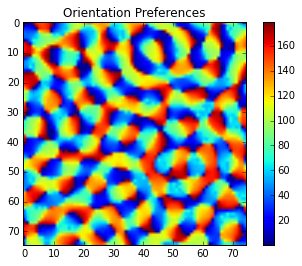

In [3]:
# Load the orientation preference map from a file

N_pairs = 75 # no. of E/I pairs to a side of a grid
field_size = 16. # size of field to a side (degrees)
dx = field_size / N_pairs

xy_range = np.linspace(0, field_size, N_pairs, False)
# xy_range = np.linspace(-field_size/2, field_size/2, N_pairs)

xv, yv = np.meshgrid(xy_range, xy_range) # x and y grid values (degrees)

# load OP map from Bryan's extracted Kaschube map
data = scipy.io.loadmat('orientation-map.mat')
OP_map = data['map']
plt.imshow(OP_map)
plt.colorbar()
plt.title('Orientation Preferences')

In [ ]:
# # Load the orientation map from an image and perform K-means
# # segmentation on it to produce orientation preferences.
# #
# # Note that this method does not produce smooth gradients of preference value

# N_pairs = 75 # no. of E/I pairs to a side of a grid
# field_size = 16. # size of field to a side (degrees)
# dx = field_size / N_pairs

# xy_range = np.linspace(0, field_size, N_pairs, False)
# # xy_range = np.linspace(-field_size/2, field_size/2, N_pairs)

# xv, yv = np.meshgrid(xy_range, xy_range) # x and y grid values (degrees)

# rgb_img = mpimg.imread('orientation-obermayer-fig1.png')

# if rgb_img.shape[2] > 3:
#     print "Throwing away the alpha channel..."
#     rgb_img = rgb_img[:,:,0:-1]

# lab_img = color.rgb2lab(rgb_img) # convert to L*a*b* colourspace

# ab = lab_img[:,:,1:]
# n_rows = np.shape(ab)[0]
# n_cols = np.shape(ab)[1]

# ab = np.reshape(ab, (n_rows*n_cols, 2))
# n_colours = 30

# centroids, labels = kmeans2(ab, n_colours)

# labels = np.reshape(labels, (n_rows, n_cols))

# rgb_labels = np.tile(labels[:,:,None], [1,1,3])

# OP_range = np.linspace(0, 180, n_colours, endpoint=False)
# full_OP_map = np.copy(labels)

# for i in range(n_colours):
#     seg_img = np.copy(rgb_img)
#     seg_img[rgb_labels != i] = 0  
    
#     # assign an orientation preference (degrees) based on segmentation
#     full_OP_map[full_OP_map == i] = OP_range[i]
    
#     # Show the individual segmented images:
# #     plt.figure()
# #     plt.imshow(seg_img)

# OP_map = full_OP_map[-N_pairs:, -N_pairs:]

# plt.figure()
# plt.imshow(OP_map)
# plt.colorbar()
# plt.title("Orientation Preferences")

[ 0.30859375  0.40234375  0.4609375   0.48828125  0.578125    0.7109375 ]


<matplotlib.colorbar.Colorbar instance at 0x1082e9e18>

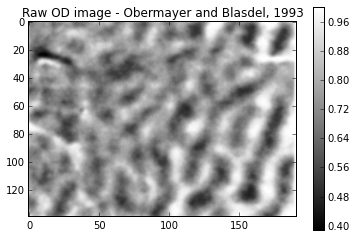

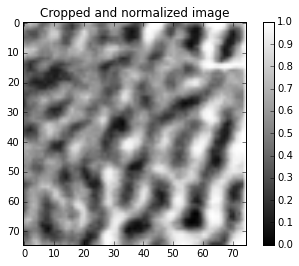

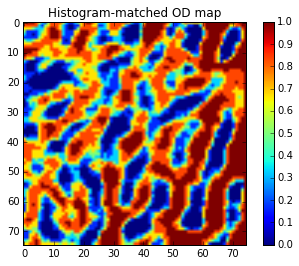

In [5]:
# Ocular dominance map: from Obermayer and Blasdel, 1993
# which contains images of ocular dominance and orientation preference from the same region

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

OD_raw = mpimg.imread('ocular-dom-obermayer-fig1.png')    
OD_gray = rgb2gray(OD_raw)    
plt.figure()
plt.imshow(OD_gray, cmap = plt.get_cmap('gray'))
plt.title("Raw OD image - Obermayer and Blasdel, 1993")
plt.colorbar()

# OD_img = OD_gray[-N_pairs-1:-1, -N_pairs-1:-1]

# subsample the Blasdel images to get (approximately) the right scale of OD map
inds = np.round(np.linspace(0,OD_gray.shape[0], N_pairs, False)).astype(int)
OD_img = OD_gray[inds[:,np.newaxis],inds+OD_gray.shape[1]-OD_gray.shape[0]]

OD_norm = (OD_img - np.min(OD_img) ) / np.max(OD_img - np.min(OD_img))

plt.figure()
plt.imshow(OD_norm, cmap = plt.get_cmap('gray'))
plt.title("Cropped and normalized image")
plt.colorbar()

OD_img_hist, OD_img_bins = np.histogram(OD_norm, bins=256)

OD_img_CDF = np.cumsum(np.array(OD_img_hist).astype(float)/np.sum(OD_img_hist))

# Scale ocular dominance map based on complex cell distribution in 
# layer 3, Hubel and Wiesel 1968, fig. 14, wherein cells are divided into
# 7 groups, 1 meaning total preference for the ipsilateral eye, and 7 for
# total contralateral dominance
OD_target_dist = np.array([26., 22., 17., 9., 30., 37., 35.])
OD_target_prop = OD_target_dist/np.sum(OD_target_dist)
OD_target_CDF = np.cumsum(OD_target_prop)

ocularity_vals = np.linspace(0,1, len(OD_target_dist), endpoint=True)

boundaries = np.zeros(len(OD_target_dist)-1)
j = 0
for i in range(len(OD_img_CDF)):
    if OD_img_CDF[i] >= OD_target_CDF[j] and j < len(OD_target_dist)-1:
        boundaries[j] = i/256.
        j = j+1

print boundaries
        
OD_map = np.zeros_like(OD_norm)

for i in range(len(boundaries)):
    if i == 0:
        OD_map[OD_norm <= boundaries[i]] = ocularity_vals[0]
    elif i == len(boundaries)-1:
        OD_map[OD_norm > boundaries[i]] = ocularity_vals[-1]
        OD_map[np.logical_and(OD_norm < boundaries[i], OD_norm >= boundaries[i-1])] = ocularity_vals[-2]
    else:
        OD_map[np.logical_and(OD_norm <= boundaries[i], OD_norm > boundaries[i-1])] = ocularity_vals[i]
        

plt.figure()
plt.title("Histogram-matched OD map")
plt.imshow(OD_map)
plt.colorbar()

In [15]:
# Connection weight parameters (from supp. materials S1.1.2):
kappa_E = 0.1
kappa_I = 0.5

# kappa_E = 0.18
# kappa_I = .85

J_EE = 0.1
J_IE = 0.38
J_EI = 0.089
J_II = 0.096

sig_EE = 8*dx
sig_IE = 12*dx
sig_EI = 4*dx
sig_II = 4*dx
sig_ori = 45
sig_OD = .25

# calculate probability of no connections for each neuron (sparse connectivity)

G_EE = np.zeros((N_pairs**2, N_pairs, N_pairs))
G_IE = np.copy(G_EE)

# may not need these
G_EI = np.copy(G_EE)
G_II = np.copy(G_EE)

G_ori = np.copy(G_EE)
G_OD = np.copy(G_EE)

pW_EE = np.copy(G_EE)
pW_IE = np.copy(G_EE)
pW_EI = np.copy(G_EE)
pW_II = np.copy(G_EE)

rnd_EE = np.copy(G_EE)
rnd_IE = np.copy(G_EE)
rnd_EI = np.copy(G_EE)
rnd_II = np.copy(G_EE)
np.random.seed(1)

# iterate through each E/I pair:
for i in range(N_pairs):
    for j in range(N_pairs):
        G_EE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EE)
        G_IE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_IE)
        G_EI[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EI)
        G_II[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_II)
        
        G_ori[N_pairs*i+j,:,:] = G(OP_map[j,i], OP_map, sig_ori)
        
        # Does ocular dominance affect connectivity? 
        # Not according to Lowel and Singer, 1992, pg. 210-11:
        # "Analyses... provided no evidence for eye-specific selectivity of tangential connections"
        # Leaving this commented for future experiments though:
#         G_OD[N_pairs*i+j,:,:] = G(OD_map[j,i], OD_map, sig_OD)
        
        rnd_EE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_IE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_EI[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_II[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)

for i in range(N_pairs**2):
    pW_EE[i,:,:] = kappa_E * np.multiply(G_EE[i,:,:], G_ori[i,:,:])
    pW_IE[i,:,:] = kappa_E * np.multiply(G_IE[i,:,:], G_ori[i,:,:])
    pW_EI[i,:,:] = kappa_I * np.multiply(G_EI[i,:,:], G_ori[i,:,:])
    pW_II[i,:,:] = kappa_I * np.multiply(G_II[i,:,:], G_ori[i,:,:])
      # for OD connectivity experiements:
#     pW_EE[i,:,:] = kappa_E * G_EE[i,:,:] * G_ori[i,:,:] * G_OD[i,:,:]
#     pW_IE[i,:,:] = kappa_E * G_IE[i,:,:] * G_ori[i,:,:] * G_OD[i,:,:]
#     pW_EI[i,:,:] = kappa_I * G_EI[i,:,:] * G_ori[i,:,:] * G_OD[i,:,:]
#     pW_II[i,:,:] = kappa_I * G_II[i,:,:] * G_ori[i,:,:] * G_OD[i,:,:]
    
# find zero-weighted connections:
W_EE = np.ones((N_pairs**2, N_pairs, N_pairs))
W_IE = np.copy(W_EE)
W_EI = np.copy(W_EE)
W_II = np.copy(W_EE)

W_EE[pW_EE<rnd_EE] = 0
W_IE[pW_IE<rnd_IE] = 0
W_EI[pW_EI<rnd_EI] = 0
W_II[pW_II<rnd_II] = 0

u_EE = mean_connections(W_EE)
u_IE = mean_connections(W_IE)
u_EI = mean_connections(W_EI)
u_II = mean_connections(W_II)

In [7]:
# Print mean number of connections:
print u_EE, u_IE, u_EI, u_II

21.7978666667 43.5578666667 31.7395555556 31.8657777778


In [8]:
# For non-zero connections, determine the weight 
W_EE[W_EE != 0] = np.random.normal(J_EE, 0.25*J_EE, W_EE[W_EE!=0].size)
W_IE[W_IE != 0] = np.random.normal(J_IE, 0.25*J_IE, W_IE[W_IE!=0].size)
W_EI[W_EI != 0] = np.random.normal(J_EI, 0.25*J_EI, W_EI[W_EI!=0].size)
W_II[W_II != 0] = np.random.normal(J_II, 0.25*J_II, W_II[W_II!=0].size)

# Set negative weights to zero:
W_EE[W_EE < 0] = 0
W_IE[W_IE < 0] = 0
W_EI[W_EI < 0] = 0
W_II[W_II < 0] = 0

# "Weights of a given type 'b' onto each unit 
# are then scaled so that all units of a given type 'a' receive the same 
# total type b synaptic weight, equal to Jab times the mean number of 
# connections received under p (Wab(x, x′) ̸= 0)"
for i in range(N_pairs**2):
    if np.all(W_EE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EE[i,:,:] = W_EE[i,:,:]*J_EE*u_EE/np.sum(W_EE[i,:,:])
    
    if np.all(W_IE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_IE[i,:,:] = W_IE[i,:,:]*J_IE*u_IE/np.sum(W_IE[i,:,:])

    if np.all(W_EI[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EI[i,:,:] = W_EI[i,:,:]*J_EI*u_EI/np.sum(W_EI[i,:,:])

    if np.all(W_II[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_II[i,:,:] = W_II[i,:,:]*J_II*u_II/np.sum(W_II[i,:,:])

In [9]:
# Model simulation parameters (from supplementary methods)
sig_FF = 32
sig_RF = dx

k   = np.random.normal(0.012, 0.05*0.012, (N_pairs, N_pairs))
n_E = np.random.normal(2.0, 0.05*2.0, (N_pairs, N_pairs)) 
n_I = np.random.normal(2.2, 0.05*2.2, (N_pairs, N_pairs))
tau_E = np.random.normal(0.02, 0.05*0.02, (N_pairs, N_pairs))
tau_I = np.random.normal(0.01, 0.05*0.01, (N_pairs, N_pairs))

In [10]:
# From S.1.3.2: for strongest nonlinear behaviour, omega_E < 0 and omega_E < omega_I
# where omega_E = sum(W_II) - sum(W_EI), omega_I = sum(W_IE) - sum(W_EE)
# Verify here:

omega_E = np.sum(W_II) - np.sum(W_EI)
omega_I = np.sum(W_IE) - np.sum(W_EE)

print 'Omega_E: ', omega_E
print 'Omega_I: ', omega_I

if omega_E < 0 and omega_I > omega_E:
    print "System should show strong nonlinear behaviour!"
else:
    print "System may not show strong nonlinear behaviour."

Omega_E:  1317.905
Omega_I:  80843.64
System may not show strong nonlinear behaviour.


In [22]:
# generate external drive for an oriented grating stimulus (circular or full frame)
# ori- orientation (degrees)
# size - diameter (degrees)
# centre - position in field of centre of stimulus (degrees, fsize/2 being the centre of the stimulus)
# ocularity - a scaling factor for which eye the stimulus is presented to (1 = contralateral, 0 = ipsilateral) 
# sig_RF - sigma for the stimulus mask
# sig_FF - sigma for full field
# fsize - size of field (degrees, square field)
# full_frame - bool for using the full frame instead of a mask
def generate_ext_stimulus(ori, size, centre, ocularity, sig_RF=16./75, sig_FF = 32., fsize=16., full_frame=False):
    if ocularity != 0 and ocularity != 1:
        raise ValueError('Ocularity must be either 0 (ipsilateral) or 1 (contralateral).')
    
    if centre[0] > fsize or centre[1] > fsize:
        raise ValueError('Centre of stimulus is off the grid of neurons!')
    
    G_FF = G(ori, OP_map, sig_FF)
    
    v_range = np.linspace(0, fsize, N_pairs, False)
    
    xv, yv = np.meshgrid( v_range, v_range )
    
    if full_frame==True:
        h = G_FF
    else:
        x_distance = np.abs(xv - centre[0])
        y_distance = np.abs(yv - centre[1])
        dist = np.sqrt(x_distance**2 + y_distance**2)
        mask = stimulus_mask(dist, size, sig_RF)
        h = np.multiply( mask, G_FF )
    
    if ocularity == 1:
        h = h * OD_map
    else:
        h = h * np.abs(OD_map-1)
    
    return h

def generate_mono_stimulus(ori, size, centre, sig_RF=16./75, sig_FF = 32., fsize=16., full_frame=False):
    if centre[0] > fsize or centre[1] > fsize:
        raise ValueError('Centre of stimulus is off the grid of neurons!')
        
    G_FF = G(ori, OP_map, sig_FF)
    
    v_range = np.linspace(0, fsize, N_pairs, False)
    
    xv, yv = np.meshgrid( v_range, v_range )
    
    if full_frame==True:
        h = G_FF
    else:
        x_distance = np.abs(xv - centre[0])
        y_distance = np.abs(yv - centre[1])
        dist = np.sqrt(x_distance**2 + y_distance**2)
        mask = stimulus_mask(dist, size, sig_RF)
        h = np.multiply( mask, G_FF )
    
    return h

# generate external drive for an annular stimulus for surround suppression experiments
# orientation - of the stimulus (degrees)
# inner_d - inner diameter of the stimulus (degrees)
# outer_d - inner diameter of the stimulus (degrees
# ocularity - a scaling factor for which eye the stimulus is presented to (1 = contralateral, 0 = ipsilateral)
# mono - boolean for generating a monocular stimulus
# centre - about which the ring is placed
def generate_ring_stimulus(orientation, inner_d, outer_d, centre, ocularity, mono=False, sig_RF=16./75, sig_FF = 32., fsize=16.):
    if centre[0] > fsize or centre[1] > fsize:
        raise ValueError('Centre of stimulus is off the grid of neurons!')
        
    if ocularity != 0 and ocularity != 1 and mono==False:
        raise ValueError('Ocularity must be either 0 (ipsilateral) or 1 (contralateral).')
    
    if inner_d >= outer_d:
        raise ValueError('Inner diameter must be less than the outer diameter (duh).')
    
    G_FF = G(orientation, OP_map, sig_FF)

    v_range = np.linspace(0, fsize, N_pairs, False)
    
    xv, yv = np.meshgrid( v_range, v_range )
    x_distance = np.abs(xv - centre[0])
    y_distance = np.abs(yv - centre[1])
    dist = np.sqrt(x_distance**2 + y_distance**2)
    
    ring_mask = stimulus_mask(dist, outer_d, sig_RF) - stimulus_mask(dist, inner_d, sig_RF)
    
    if mono == False:
        if ocularity == 1:
            h = ring_mask * G_FF * OD_map
        else:
            h = ring_mask * G_FF * np.abs(OD_map-1)
    else:
        h = ring_mask * G_FF
    
    return h

In [12]:
def run_simulation( dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II, init_cond=[np.zeros((N_pairs, N_pairs)),np.zeros((N_pairs, N_pairs))]):
    r_E = np.zeros((timesteps, N_pairs, N_pairs))
    r_I = np.copy(r_E)

    # add initial conditions:
    r_E[0,:,:] = init_cond[0]
    r_I[0,:,:] = init_cond[1]

    I_E = np.zeros((timesteps, N_pairs, N_pairs))
    I_I = np.copy(I_E)
    # rSS_E = np.copy(I_E)
    # rSS_I = np.copy(I_I)

    for t in range(1,timesteps):
        # Input drive from external input and network
        I_E[t,:,:] = c*h + np.sum( np.sum( W_EE * r_E[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T - np.sum( np.sum( W_EI * r_I[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T 
        I_I[t,:,:] = c*h + np.sum( np.sum( W_IE * r_E[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T - np.sum( np.sum( W_II * r_I[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T 
        
        # steady state firing rates - power law I/O
        rSS_E = np.multiply(k, np.power(np.fmax(0,I_E[t,:,:]), n_E))
        rSS_I = np.multiply(k, np.power(np.fmax(0,I_I[t,:,:]), n_I))

        # set negative steady state rates to zero
        rSS_E[rSS_E < 0] = 0
        rSS_I[rSS_I < 0] = 0

        # instantaneous firing rates approaching steady state
        r_E[t,:,:] = r_E[t-1,:,:] + dt*(np.divide(-r_E[t-1,:,:]+rSS_E, tau_E))
        r_I[t,:,:] = r_I[t-1,:,:] + dt*(np.divide(-r_I[t-1,:,:]+rSS_I, tau_I))
        
    return [r_E, r_I, I_E, I_I]

In [13]:
# For a given set of weights, find units that show strong surround suppression
# Surround suppression index (SSI) as defined by Rubin et al, 2015:
# SSI = r_max - r_full / r_max, where r_max is the max firing rate to stimuli shorter
# than 2/3 of full field, and r_full = firing rate at full field 
def find_SS_units(W_EE, W_EI, W_IE, W_II, OP_map, h_bank, r_units, SSI_thresh=0.25, N_pairs=75, fsize=16.):

    c = 40
    dt = 0.005
    timesteps = 100
    
    n_samples = len(r_units)
    
    if n_samples > W_EE.size:
        raise ValueError("Number of samples must be less than or equal to the number of units")
    
    # keep two lists of units which show strong surround suppression
    SS_E = np.empty((0,2))
    SS_I = np.empty((0,2))
                      
    results_E = np.zeros((n_samples, h_bank.shape[1]))
    results_I = np.zeros((n_samples, h_bank.shape[1]))                      
                      
    for i in range(n_samples):
        xi = r_units[i,0]
        yi = r_units[i,1]         
        r_E_max = 0
        r_I_max = 0                   
        for j in range(h_bank.shape[1]):
            h = h_bank[i,j,:,:]
            [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
            
            results_E[i,j] = r_E[-1,yi,xi]
            results_I[i,j] = r_I[-1,yi,xi]
                      
            if r_E_max < r_E[-1,yi,xi]: 
                r_E_max = r_E[-1,yi,xi]

            if r_I_max < r_I[-1,yi,xi]:
                r_I_max = r_I[-1,yi,xi]              
        
        r_E_ff = r_E[-1,yi,xi]
        if (r_E_max - r_E_ff)/r_E_max > SSI_thresh:
            SS_E = np.append(SS_E, [r_units[i,:]], axis=0)
                             
        r_I_ff = r_I[-1,yi,xi]
        if (r_I_max - r_I_ff)/r_I_max > SSI_thresh:
            SS_I = np.append(SS_I, [r_units[i,:]], axis=0)                             
                      
        
    return [SS_E, SS_I, results_E, results_I]

In [15]:
# randomly select n units:
n_samples = 80
r_units = np.floor(N_pairs*np.random.rand(n_samples, 2))

fsize = 16.
N_pairs = 75
dx = fsize/N_pairs

# generate the external drive bank with a full frame stimulus at the end
stim_sizes = np.linspace(0.5, 16.*2/3., 10)
h_bank = np.zeros((n_samples, len(stim_sizes)+1, N_pairs, N_pairs ) )
for i in range(n_samples):
    xi = r_units[i,0]
    yi = r_units[i,1]
    for j in range(len(stim_sizes)):
        h_bank[i,j,:,:] = generate_mono_stimulus(OP_map[yi,xi], stim_sizes[j], [dx*xi,dx*yi])

    h_bank[i,-1,:,:] = generate_mono_stimulus(OP_map[yi,xi], 0, [0,0], full_frame=True)

In [16]:
start_time = time.time()
[SS_E, SS_I, results_E, results_I] = find_SS_units(W_EE, W_EI, W_IE, W_II, OP_map, h_bank, r_units)
print "Elapsed time: ", time.time()-start_time
print "%d E units and %d I units show strong surround suppression." % (len(SS_E), len(SS_I))


Elapsed time:  29699.296057
77 E units and 45 I units show strong surround suppression.
[[ 42.  71.]
 [ 51.  39.]
 [ 36.  25.]
 [ 62.  63.]
 [ 62.  11.]
 [ 23.  74.]
 [ 64.  44.]
 [ 44.   8.]
 [ 61.  21.]
 [ 60.  10.]
 [ 28.   1.]
 [ 67.   0.]
 [ 32.  43.]
 [ 61.  40.]
 [ 62.  70.]
 [  3.  37.]
 [ 20.  46.]
 [ 31.  30.]
 [ 72.  70.]
 [ 70.   8.]
 [ 22.  42.]
 [ 28.  74.]
 [ 74.  28.]
 [ 17.  36.]
 [ 15.  59.]
 [ 46.  54.]
 [ 66.  16.]
 [ 10.  15.]
 [  6.   4.]
 [ 59.  11.]
 [ 42.  65.]
 [ 71.  48.]
 [ 51.   2.]
 [  3.  35.]
 [ 37.  21.]
 [ 12.  44.]
 [ 21.  58.]
 [ 63.  18.]
 [ 72.  38.]
 [ 43.  46.]
 [ 25.  35.]
 [ 38.  54.]
 [ 28.  65.]
 [ 35.  48.]
 [  5.  38.]
 [ 45.   1.]
 [ 61.  69.]
 [  9.  11.]
 [ 14.  39.]
 [ 53.  21.]
 [ 64.  18.]
 [ 56.  13.]
 [ 74.  61.]
 [ 10.  49.]
 [ 40.  40.]
 [ 66.  46.]
 [ 26.  74.]
 [ 73.  61.]
 [ 70.  35.]
 [ 73.  29.]
 [ 44.  68.]
 [ 12.  41.]
 [ 61.  41.]
 [ 29.  36.]
 [ 20.  32.]
 [  1.  32.]
 [ 11.  64.]
 [ 52.  58.]
 [  5.   5.]
 [ 29.  27.]
 [

In [90]:
overlap = np.empty((0,2))
overlap_flags = np.zeros(len(SS_E))-1
others = np.empty((0,2))
for i in range(len(SS_I)):
    added = False
    for j in range(len(SS_E)):
        if np.all(SS_I[i,:]==SS_E[j,:]):
            overlap = np.append(overlap, SS_I[i,:].reshape(1,2), axis=0)
            overlap_flags[j] = i
            added = True
            break
    if added==False:
        others = np.append(others, SS_I[i,:].reshape(1,2), axis=0)

print "%d of %d I units are also E units, and %d are not." % (len(overlap), len(others)+len(overlap), len(others))

43 of 45 I units are also E units, and 2 are not.


In [93]:
# Find the summation field size of each neuron showing strong surround suppression

sum_field_sizes_E = np.zeros(len(SS_E))
sum_field_sizes_I = np.zeros(len(SS_I))
stim_sizes = np.linspace(0.5, 3, 10)
h_bank = np.zeros((len(SS_E), len(stim_sizes), N_pairs, N_pairs))

for i in range(len(SS_E)):
    for j in range(len(stim_sizes)):
        yi = SS_E[i,1]
        xi = SS_E[i,0]
        h_bank[i,j,:,:] = generate_mono_stimulus(OP_map[yi,xi], stim_sizes[j], [dx*xi, dx*yi])

c = 40
dt = 0.005
timesteps = 100
overlap_count = 0
sim_count = 0

start_time = time.time()

for i in range(len(SS_E)):
    yi = SS_E[i,1]
    xi = SS_E[i,0]
    max_fr_E = 0
    max_fr_I = 0
    I_found = False
    E_found = False
    
    for j in range(len(stim_sizes)):
        if (I_found == False and E_found == False and overlap_flags[i]!=-1) or (overlap_flags[i]==-1 and E_found==False):
            h = h_bank[i,j,:,:]
            [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
            sim_count = sim_count + 1
            
            if r_E[-1,yi,xi] >= max_fr_E:
                max_fr_E = r_E[-1,yi,xi]
            else:
                sum_field_sizes_E[i] = stim_sizes[j-1]
                E_found = True
            if overlap_flags[i] != -1:
                if r_I[-1,yi,xi] > max_fr_I:
                    max_fr_I = r_I[-1,yi,xi]
                else:
                    sum_field_sizes_I[overlap_flags[i]] = stim_sizes[j-1]
                    I_found = True
                    
    if E_found == False and max_fr_E!=0:
        sum_field_sizes_E[i] = stim_sizes[-1]
    if I_found == False and overlap_flags[i]!=-1 and max_fr_I !=0:
        sum_field_sizes_I[overlap_flags[i]] == stim_sizes[-1]
                    
print "Elapsed time for %d simulations: %d seconds" % (sim_count, time.time()-start_time)

Elapsed time for 364 simulations: 12796 seconds


In [94]:
print sum_field_sizes_E
print '================'
print sum_field_sizes_I

[ 1.61111111  1.33333333  1.33333333  1.33333333  1.05555556  1.05555556
  1.05555556  1.33333333  1.33333333  1.33333333  1.61111111  1.05555556
  1.33333333  1.61111111  1.05555556  1.33333333  3.          1.61111111
  1.05555556  1.05555556  1.33333333  1.05555556  1.33333333  1.05555556
  1.05555556  1.33333333  1.05555556  1.33333333  1.33333333  1.33333333
  1.05555556  1.05555556  3.          2.44444444  1.33333333  1.05555556
  3.          1.33333333  1.05555556  1.05555556  1.33333333  3.
  1.05555556  0.77777778  1.33333333  1.05555556  1.05555556  1.33333333
  1.05555556  1.33333333  1.33333333  1.05555556  0.77777778  1.61111111
  1.05555556  1.05555556  1.05555556  1.05555556  1.05555556  1.33333333
  1.05555556  1.33333333  1.33333333  2.44444444  1.33333333  1.33333333
  1.61111111  1.33333333  1.05555556  1.33333333  1.05555556  1.33333333
  1.05555556  1.61111111  1.61111111  3.          1.05555556]
[ 0.          0.          1.05555556  0.          1.33333333  0.      

In [95]:
# Find how large a ring stimulus is needed to avoid getting a response
# for a selection of 15 of the neurons which show strong SS:

n_units = 15
overlap_units = np.squeeze(SS_E[np.where(overlap_flags!=-1),:])
overlap_SFS = np.squeeze(sum_field_sizes_E[np.where(overlap_flags!=-1)])

r_inds = np.floor(len(overlap_units)*np.random.rand(15)).astype(int)

r_units = overlap_units[r_inds, :]

# summation field sizes of the randomly selected units:
r_SFS_E = overlap_SFS[r_inds]
r_SFS_I = np.zeros_like(r_SFS_E)
for i in range(n_units):
    for j in range(len(SS_I)):
        if np.all(SS_I[j,:]==r_units[i,:]):
            r_SFS_I[i] = sum_field_sizes_I[j]
            
print r_SFS_I

# first, make the stimulus bank, starting with rings 1 degree thick:

n_ring_sizes = 5
h_bank = np.zeros((n_units*2, n_ring_sizes, N_pairs, N_pairs))
max_ring_d = 6

for i in range(n_units):
    xi = r_units[i,0]
    yi = r_units[i,1]
    
    min_ring_d = r_SFS_E[i]
    inner_ds_E = np.linspace(min_ring_d, max_ring_d-1, n_ring_sizes)
    inner_ds_I = np.linspace(r_SFS_I[i], max_ring_d-1, n_ring_sizes)
    
    for j in range(n_ring_sizes):
        h_bank[i,j,:,:] = generate_ring_stimulus(OP_map[yi,xi], inner_ds_E[j], max_ring_d, [dx*xi, dx*yi], ocularity=1, mono=True)
        h_bank[i+n_units,j,:,:] = generate_ring_stimulus(OP_map[yi,xi], inner_ds_I[j], max_ring_d, [dx*xi, dx*yi], ocularity=1, mono=True)        
#         plt.figure()
#         plt.imshow(h_bank[i,j,:,:])
               

[ 0.          0.          0.          1.33333333  0.          0.          0.
  1.05555556  0.          1.05555556  0.          0.          1.33333333
  1.33333333  1.33333333]


Elapsed time for 75 simulations: 2608 seconds


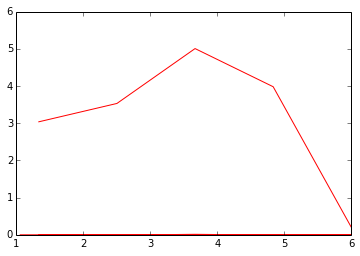

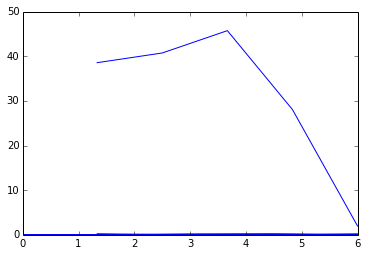

In [96]:
res_E = np.zeros((n_units, n_ring_sizes))
res_I = np.copy(res_E)

dt = 0.005
timesteps = 100
c = 40                 
sim_count = 0

st = time.time()
for i in range(n_units):
    for j in range(n_ring_sizes):
        h = h_bank[i,j,:,:]
        [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
        sim_count = sim_count+1
        res_E[i,j] = r_E[-1,yi,xi]
        res_I[i,j] = r_I[-1,yi,xi]    
        
        if r_E[-1,yi,xi]==0 and r_I[-1,yi,xi]==0:
            break

print "Elapsed time for %d simulations: %d seconds" % (sim_count, time.time()-st)
            
plt.figure()
for i in range(n_units):
    plt.plot(np.linspace(r_SFS_E[i], max_ring_d-1, n_ring_sizes), res_E[i,:], 'r')

plt.figure()
for i in range(n_units):
    plt.plot(np.linspace(r_SFS_I[i], max_ring_d-1, n_ring_sizes), res_I[i,:], 'b')

[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 3.  4.  5.  4.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------
[ 0.  0.  0.  0.  0.]
----------


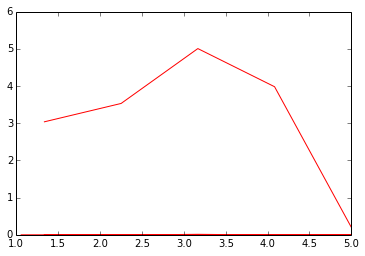

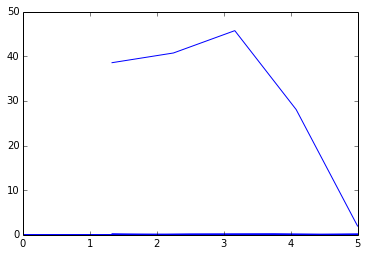

In [209]:
plt.figure()
for i in range(n_units):
    plt.plot(np.linspace(r_SFS_E[i], max_ring_d-1, n_ring_sizes), res_E[i,:], 'r')

plt.figure()
for i in range(n_units):
    plt.plot(np.linspace(r_SFS_I[i], max_ring_d-1, n_ring_sizes), res_I[i,:], 'b')

In [211]:
# find the minimum firing rate for the surround stimuli tested,
# rounding the fractional firing rates for ease of comparison

inner_d_E = np.zeros(n_units)
inner_d_I = np.copy(inner_d_E)
mfr_E = np.copy(inner_d_E)
mfr_I = np.copy(inner_d_E)

# get the first size which causes a minimum firing rate
for i in range(len(res_E)):
    min_fr_E = res_E[i,0]
    min_ind = 0
    zero_found = False
    for j in range(len(res_E[:,0])):
        if np.round(res_E[i,j])==0:
            inner_d_E[i] = np.linspace(r_SFS_E[i], max_ring_d-1, n_ring_sizes)[j]
            zero_found = True
            mfr_E[i] = 0
            break
        else:
            if res_E[i,j] < min_fr_E:
                min_fr_E = res_E[i,j]
                min_ind = j
    if zero_found == False:
        inner_d_E[i] = np.linspace(r_SFS_E[i], max_ring_d-1, n_ring_sizes)[min_ind]
        mfr_E[i] = min_fr_E
# for i in range(len(res_I)):
#     min_fr_I = res_I[i,0]
#     min_ind = 0
#     zero_found = False
#     for j in range(len(res_I[:,0])):
#         print j
#         if np.round(res_I[i,j])==0:
#             inner_d_I[i] = np.linspace(r_SFS_I[i], max_ring_d-1, n_ring_sizes)[j]
#             zero_found = True
#             break
#         else:
#             if res_I[i,j] < min_fr_I:
#                 min_fr_I = res_I[i,j]
#                 min_ind = j
#     if zero_found == False:
#         inner_d_I[i] = np.linspace(r_SFS_I[i], max_ring_d-1, n_ring_sizes)[min_ind]   
        
        
# print inner_d_I
# print '================'
print inner_d_E - r_SFS_E
print inner_d_E
print mfr_E

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          3.66666667
  0.          0.        ]
[ 1.05555556  1.05555556  1.05555556  1.33333333  1.05555556  1.33333333
  1.33333333  1.05555556  1.05555556  3.          1.33333333  1.05555556
  5.          1.33333333  1.33333333]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


0 [ 67.   0.]
1 [ 70.   8.]
2 [  8.  11.]
3 [ 61.  21.]
4 [ 64.  44.]
5 [ 64.  18.]
6 [  5.  38.]
7 [ 23.  74.]
8 [ 12.  44.]
9 [ 43.  60.]
10 [ 32.  43.]
11 [ 12.  44.]
12 [ 59.  11.]
13 [ 37.  21.]
14 [ 61.  21.]


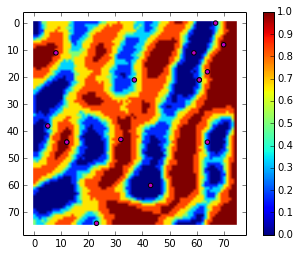

In [145]:
plt.figure()
plt.imshow(OD_map)
plt.colorbar()
plt.scatter(r_units[:,0], r_units[:,1], c='m')

for i in range(len(r_units)):
    print i, r_units[i,:]

strong_OD_inds = np.array([8,9,12,])
strong_OD_units = r_units[strong_OD_inds,:]

# these are actually weak/transition regions
strong_OD_inds = np.array([5,6,7,13,14,])
strong_OD_units = r_units[weak_OD_inds,:]

In [146]:
# generate stimuli for units with strong OD:
print r_SFS_E.shape, strong_OD_units.shape
h_bank = np.zeros((len(strong_OD_units), 5, N_pairs, N_pairs))

for i in range(len(strong_OD_units)):
    yi = strong_OD_units[i,1]
    xi = strong_OD_units[i,0]
    ori = OP_map[ yi, xi ]
    centre = [dx*xi, dx*yi]
    
    crf_d = r_SFS_E[strong_OD_inds[i]]
    inner_d = inner_d_E[strong_OD_inds[i]]
    outer_d = 6
    ocularity = np.round(OD_map[yi, xi])
    
    h_crf = generate_ext_stimulus(ori, crf_d, centre, ocularity)
    h_crf_nd = generate_ext_stimulus(ori, crf_d, centre, np.abs(ocularity-1))
    h_surr_dom = generate_ring_stimulus(ori, inner_d, outer_d, centre, ocularity)
    h_surr_non_dom = generate_ring_stimulus(ori, inner_d, outer_d, centre, np.abs(ocularity-1))
    h_surr_mono = generate_ring_stimulus(ori, inner_d, outer_d, centre, np.abs(ocularity-1), mono=True)
    
    h_bank[i,0,:,:] = h_crf
    h_bank[i,1,:,:] = h_surr_dom
    h_bank[i,2,:,:] = h_surr_non_dom
    h_bank[i,3,:,:] = h_surr_mono
    h_bank[i,4,:,:] = h_crf_nd

(15,) (5, 2)


In [149]:
# run simulations to produce fig 10a using only the HAND-SELECTED neurons

crf_results = np.zeros(len(strong_OD_units))
dom_results = np.copy(crf_results)
ndom_results = np.copy(crf_results)
mono_results = np.copy(crf_results)
crf_nd_results = np.copy(crf_results)

crf_results_I = np.zeros(len(strong_OD_units))
dom_results_I = np.copy(crf_results)
ndom_results_I = np.copy(crf_results)
mono_results_I = np.copy(crf_results)
crf_nd_results_I = np.copy(crf_results)

c = 30
dt = 0.005
timesteps = 100

for i in range(len(strong_OD_units)):
    yi = strong_OD_units[i,1]
    xi = strong_OD_units[i,0]
    h = h_bank[i,0,:,:]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    crf_results[i] = r_E[-1,yi,xi]
    crf_results_I[i] = r_I[-1,yi,xi]
    
    h = h_bank[i,0,:,:] + h_bank[i,1,:,:]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    dom_results[i] = r_E[-1,yi,xi]
    dom_results_I[i] = r_I[-1,yi,xi]
    
    h = h_bank[i,0,:,:] + h_bank[i,2,:,:]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    ndom_results[i] = r_E[-1,yi,xi]
    ndom_results_I[i] = r_I[-1,yi,xi]
    
    h = h_bank[i,0,:,:] + h_bank[i,3,:,:]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    mono_results[i] = r_E[-1,yi,xi]
    mono_results_I[i] = r_I[-1,yi,xi]
    
    h = h_bank[i,4,:,:]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    crf_nd_results[i] = r_E[-1,yi,xi]
    crf_nd_results_I[i] = r_I[-1,yi,xi]

CRF: [ 3.49322731  6.27721315  3.31964456  1.90507622  4.30643601]
Dom: [ 2.22219007  6.99884314  3.07609141  1.24883302  2.21337854]
Ndom: [ 2.61860468  4.3457688   3.24631127  0.7202464   2.85008395]
Mono: [ 1.62007219  4.43906367  2.51954511  0.0707377   1.32807907]
30


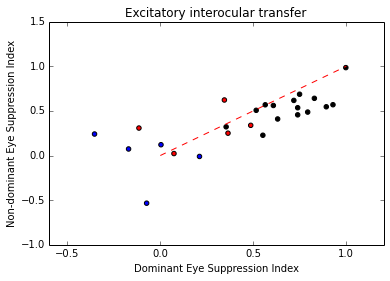

In [152]:
# Plotting for figure 10A reproduction
dom_SI_E = (crf_results - dom_results)/crf_results
nd_SI_E = (crf_results - ndom_results)/crf_results

dom_SI_I = (crf_results_I - dom_results_I)/crf_results_I
nd_SI_I = (crf_results_I - ndom_results_I)/crf_results_I

# Data from Webb et al., 2005, fig 10A:
webb_data = np.array([[0.3538, 0.3214],
[0.5513, 0.2271],
[0.5154, 0.5064],
[0.5641, 0.5681],
[0.6077, 0.5605],
[0.7179, 0.6172],
[0.7487, 0.6865],
[0.8282, 0.6406],
[0.8923, 0.5459],
[0.9282, 0.5690],
[0.6308, 0.4093],
[0.7385, 0.4557],
[0.7923, 0.4866],
[0.7385, 0.5352],
[0.9974, 0.9846]])
    
plt.figure()
plt.scatter(dom_SI_E, nd_SI_E, c='r')
plt.scatter(dom_SI_I, nd_SI_I, c='b')
plt.scatter(webb_data[:,0], webb_data[:,1], c='k')
plt.plot([0,1], [0,1], 'r--')
plt.title('Excitatory interocular transfer')
plt.xlabel("Dominant Eye Suppression Index")
plt.ylabel("Non-dominant Eye Suppression Index")

print "CRF:", crf_results
print "======"
print "CRFND:", crf_nd_results
print "======"
print "Dom:", dom_results
print "======"
print "Ndom:", ndom_results
print "======"
print "Mono:", mono_results
print "======"

print c

Ocularity:  0.0
Dom SI:  0.0300015601401
non-dom SI:  0.302830031931
Mono SI:  0.307539037822
CRF diff: 1.0
Dom img drive:  62.413499479
Non dom img drive:  128.360294514
mono drive: 190.773793993
Sum:  190.773793993
This cell DOES NOT show the expected suppression.


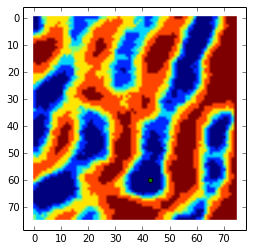

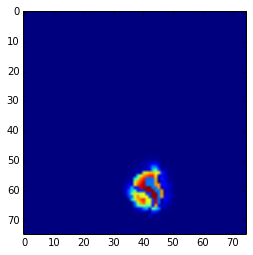

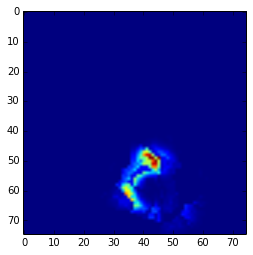

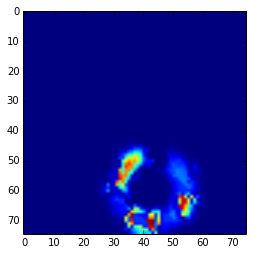

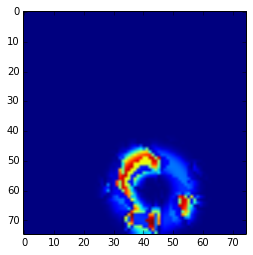

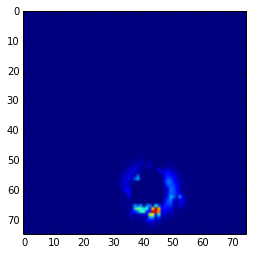

In [214]:
ind = 1
cell = strong_OD_units[ind]

plt.figure()
plt.imshow(OD_map)
plt.scatter(cell[0], cell[1], c='g')

print "Ocularity: ", OD_map[cell[1], cell[0]]

print "Dom SI: ", dom_SI_E[ind]
print "non-dom SI: ", nd_SI_E[ind]
print "Mono SI: ", (crf_results[ind] - mono_results[ind])/crf_results[ind]
print "CRF diff:", (crf_results[ind] - crf_nd_results[ind])/crf_results[ind]

print "Dom img drive: ", np.sum(h_bank[ind,1,:,:])
print "Non dom img drive: ", np.sum(h_bank[ind,2,:,:])
print "mono drive:", np.sum(h_bank[ind,3,:,:])
print "Sum: ", np.sum(h_bank[ind,1,:,:]) + np.sum(h_bank[ind,2,:,:])

if dom_SI_E[ind] >= nd_SI_E[ind] and nd_SI_I[ind] > 0:
    print "This cell shows the expected suppression."
else:
    print "This cell DOES NOT show the expected suppression."

for i in range(len(h_bank[ind,:,:,:])):
    plt.figure()
    plt.imshow(h_bank[ind,i,:,:])

Ocularity:  0.333333333333
Dom SI:  0.00355858043997
non-dom SI:  0.12085903671
Mono SI:  0.626517833974
CRF diff: 0.746419944845
This cell DOES NOT show the expected suppression.


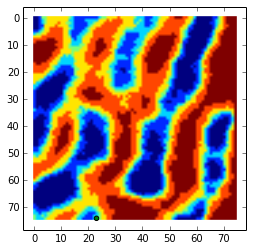

In [186]:
ind = 2
cell = strong_OD_units[ind]

plt.figure()
plt.imshow(OD_map)
plt.scatter(cell[0], cell[1], c='g')

print "Ocularity: ", OD_map[cell[1], cell[0]]

print "Dom SI: ", dom_SI_I[ind]
print "non-dom SI: ", nd_SI_I[ind]
print "Mono SI: ", (crf_results_I[ind] - mono_results_I[ind])/crf_results_I[ind]
print "CRF diff:", (crf_results_I[ind] - crf_nd_results_I[ind])/crf_results_I[ind]

print "Dom img drive: ", np.sum(h_bank[ind,1,:,:])
print "Non dom img drive: ", np.sum(h_bank[ind,2,:,:])

if dom_SI_I[ind] >= nd_SI_I[ind] and nd_SI_I[ind] > 0:
    print "This cell shows the expected suppression."
else:
    print "This cell DOES NOT show the expected suppression."

# for i in range(len(h_bank[ind,:,:,:])):
#     plt.figure()
#     plt.imshow(h_bank[ind,i,:,:])

In [ ]:
# Reproduce figure 6E using the identified neurons:

# convert the lists to scalar indices for ease of comparison
r_inds = r_units[:,0] + r_units[:,1]*N_pairs
E_inds = SS_E[:,0] + SS_E[:,1]*N_pairs
I_inds = SS_I[:,0] + SS_I[:,1]*N_pairs

r_SSI_E = np.empty( (0,1) )
for i in E_inds:
    r_SSI_E = np.append( r_SSI_E, np.where(i==r_inds), axis=0 )

plt.figure()
plt.plot(stim_sizes, np.mean(results_E[r_SSI_E.flatten().astype(int),:-1],0), 'r')
plt.title("E units showing strong SS")
plt.xlabel("Stimulus Size (degrees)")
plt.ylabel("Firing Rate (Hz)")

plt.savefig('results/fig6e-OD-E-units-%dof%d' %  (len(E_inds), n_samples)) 
r_SSI_I = np.empty( (0,1) )
for i in I_inds:
    r_SSI_I = np.append( r_SSI_I, np.where(i==r_inds), axis=0 )
  
plt.figure()
plt.plot(stim_sizes, np.mean(results_I[r_SSI_I.flatten().astype(int),:-1], 0), 'b')
plt.title("I units showing strong SS")
plt.xlabel("Stimulus Size (degrees)")
plt.ylabel("Firing Rate (Hz)")

plt.savefig('results/fig6e-OD-I-units-%dof%d' %  (len(I_inds), n_samples))

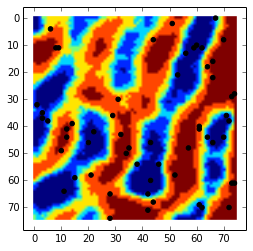

In [42]:
# randomly select 10 neurons with strong OD and strong SS and generate stimuli for them:
OD_vals = np.linspace(0,1,7,True)
# OD_units = np.where( np.logical_or(OD_map <= OD_vals[1], OD_map >= OD_vals[-2]) )

OD_units = np.empty( (0,2) )
for i in SS_E:
    if np.logical_or(OD_map[i[1], i[0]] <= OD_vals[1], OD_map[i[1], i[0]] >= OD_vals[-2]):
        i = i.reshape(1,2) 
        OD_units = np.append(OD_units, i, axis=0)       

plt.figure()
plt.imshow(OD_map)
plt.scatter(OD_units[:,0], OD_units[:,1], c='k')    
# r_units = np.floor(len(OD_units[0])*np.random.rand(10, 2))
# xinds = OD_units[1][r_units[:,0].astype(int)]
# yinds = OD_units[0][r_units[:,1].astype(int)]

xinds = OD_units[:,0]
yinds = OD_units[:,1]

# store stimuli for the dominant eye CRF, dominant eye surround, and non-dominant eye surround
h_bank = np.zeros((N_pairs, N_pairs, len(OD_units), 3))

# stimulus parameters - based on Webb et al., 2005: 
crf_d = 1

# try to use an inner diameter that will evoke no response:
inner_d = 3 # twice the sig_IE
outer_d = 4

# generate stimulus bank
for i in range(len(OD_units)):
    
    ori = OP_map[ yinds[i], xinds[i] ]
    centre = [dx*xinds[i], dx*yinds[i]]
    
    ocularity = np.round(OD_map[yinds[i], xinds[i]])
    
    h_surr_dom = generate_ring_stimulus(ori, inner_d, outer_d, centre, ocularity)
    
    h_crf = generate_ext_stimulus(ori, crf_d, centre, ocularity)
    
    h_surr_non_dom = generate_ring_stimulus(ori, inner_d, outer_d, centre, np.abs(ocularity-1))
    
#     plt.figure()
#     plt.imshow(h_crf)
#     plt.title('CRF drive')

#     plt.figure()
#     plt.imshow(h_surr_dom)
#     plt.title('Dominant Eye Surround drive')

#     plt.figure()
#     plt.imshow(h_surr_non_dom)
#     plt.title('Non-dominant Eye Surround drive')
    
    h_bank[:,:,i,0] = h_crf
    h_bank[:,:,i,1] = h_surr_dom
    h_bank[:,:,i,2] = h_surr_non_dom

In [43]:
# Run simulations to reproduce fig 10A of Webb et al., 2005

dt = 0.005
timesteps = 100
c = 50

results_r_E = np.zeros((len(OD_units), 3, timesteps, N_pairs, N_pairs))
results_r_I = np.copy(results_r_E)
results_I_E = np.copy(results_r_E)
results_I_I = np.copy(results_r_E)

start_time = time.time()
for i in range(len(OD_units)):
    # simulation for CRF only:
    h = h_bank[:,:,i,0]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    results_r_E[i,0,:,:,:] = r_E
    results_r_I[i,0,:,:,:] = r_I
    results_I_E[i,0,:,:,:] = I_E
    results_I_I[i,0,:,:,:] = I_I
        
    # simulation for CRF and dominant-eye surround:
    h = h_bank[:,:,i,0] + h_bank[:,:,i,1]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    results_r_E[i,1,:,:,:] = r_E
    results_r_I[i,1,:,:,:] = r_I
    results_I_E[i,1,:,:,:] = I_E
    results_I_I[i,1,:,:,:] = I_I
        
    # simulation for CRF and non-dominant-eye surround:
    h = h_bank[:,:,i,0] + h_bank[:,:,i,2]
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    results_r_E[i,2,:,:,:] = r_E
    results_r_I[i,2,:,:,:] = r_I
    results_I_E[i,2,:,:,:] = I_E
    results_I_I[i,2,:,:,:] = I_I
    
print "Elasped time: ", time.time() - start_time

Elasped time:  6138.86538196


In [ ]:
# Calculate suppression index (SI) for each neuron
# From Webb et al., 2005, pg. 11667:
# SI = R_pref - R_pref+annulus / R_pref

# Reproducing fig 10A: transfer ratio:
# non-dominant SI / dominant SI
# median transfer ratio: 0.77 +/- 0.05

r_pref_E = np.zeros(len(OD_units))
r_dom_E = np.copy(r_pref_E)
r_nd_E = np.copy(r_pref_E)
r_pref_I = np.zeros(len(OD_units))
r_dom_I = np.copy(r_pref_I)
r_nd_I = np.copy(r_pref_I)

for i in range(len(OD_units)):
    r_pref_E[i] = results_r_E[i,0,-1,yinds[i],xinds[i]]
    r_dom_E[i]  = results_r_E[i,1,-1,yinds[i],xinds[i]]
    r_nd_E[i]   = results_r_E[i,2,-1,yinds[i],xinds[i]]
    
    r_pref_I[i] = results_r_I[i,0,-1,yinds[i],xinds[i]]
    r_dom_I[i]  = results_r_I[i,1,-1,yinds[i],xinds[i]]
    r_nd_I[i]   = results_r_I[i,2,-1,yinds[i],xinds[i]]

r_pref_I = np.round(r_pref_I)

dom_SI_E = (r_pref_E - r_dom_E)/r_pref_E
nd_SI_E = (r_pref_E - r_nd_E)/r_pref_E
                         
# Data from Webb et al., 2005, fig 10A:
webb_data = np.array([[0.3538, 0.3214],
[0.5513, 0.2271],
[0.5154, 0.5064],
[0.5641, 0.5681],
[0.6077, 0.5605],
[0.7179, 0.6172],
[0.7487, 0.6865],
[0.8282, 0.6406],
[0.8923, 0.5459],
[0.9282, 0.5690],
[0.6308, 0.4093],
[0.7385, 0.4557],
[0.7923, 0.4866],
[0.7385, 0.5352],
[0.9974, 0.9846]])
    
plt.figure()
plt.scatter(dom_SI_E, nd_SI_E, c='r')
plt.scatter(webb_data[:,0], webb_data[:,1], c='k')
plt.plot([0,1], [0,1], 'r--')
plt.title('Excitatory interocular transfer')
plt.xlabel("Dominant Eye Suppression Index")
plt.ylabel("Non-dominant Eye Suppression Index")
# plt.savefig('results/fig-10a_SI_E-c%d-id%d-od%d-SSI' % (c,inner_d, outer_d) )

dom_SI_I = (r_pref_I - r_dom_I)/r_pref_I
nd_SI_I = (r_pref_I - r_nd_I)/r_pref_I

plt.figure()
plt.scatter(dom_SI_I, nd_SI_I, c='c')
plt.scatter(webb_data[:,0], webb_data[:,1], c='k')
plt.plot([-1,1], [-1,1], 'b--')
plt.xlabel("Dominant Eye Suppression Index")
plt.ylabel("Non-dominant Eye Suppression Index")
plt.title('Inhibitory interocular transfer')

# plt.savefig('results/fig-10a_SI_I-c%d-id%d-od%d-SSI' % (c,inner_d, outer_d) )